# Opentender.eu datasets for European Institutions

## Load and transform dataset
Datasets downloaded in json format from https://opentender.eu/all/download for EU institutions. Extract and store the archives in `data_json_opentender/data-eu-json`.

In [1]:
country_code = "eu"

In [2]:
import glob
import json
import pandas as pd
from fastlid import fastlid

cols = ['title_description', 'cpvs']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        cpvs = element.get("cpvs", [])
        result_cpvs = []
        for cpv in cpvs:
            result = cpv.get("code", "na")
            if result and result != "na":
                result = result[:2]
                if result in all_divisions:
                    result_cpvs.append(result)
        title = element.get('title', '')
        if title:
            title = f'{title}. '
        description = element.get('description', '')

        title_description = f'{title}{description}'
        fastlid_output = fastlid(title_description)
        lang = fastlid_output[0]
        confidence = fastlid_output[1]
        #if lang == "en" and confidence > 0.4:
        if result_cpvs and title_description:
            lst = [title_description, result_cpvs]
            data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-eu-json/data-eu-2020.json', 'data_json_opentender/data-eu-json/data-eu-2015.json', 'data_json_opentender/data-eu-json/data-eu-2018.json', 'data_json_opentender/data-eu-json/data-eu-2022.json', 'data_json_opentender/data-eu-json/data-eu-2009.json', 'data_json_opentender/data-eu-json/data-eu-2011.json', 'data_json_opentender/data-eu-json/data-eu-year-unavailable.json', 'data_json_opentender/data-eu-json/data-eu-2014.json', 'data_json_opentender/data-eu-json/data-eu-2013.json', 'data_json_opentender/data-eu-json/data-eu-2017.json', 'data_json_opentender/data-eu-json/data-eu-2012.json', 'data_json_opentender/data-eu-json/data-eu-2016.json', 'data_json_opentender/data-eu-json/data-eu-2019.json', 'data_json_opentender/data-eu-json/data-eu-2010.json', 'data_json_opentender/data-eu-json/data-eu-2021.json']


title_description  cpvs
36746  Tonere multifunctionale. Se achizitioneaza ton...  [30]
36747  Cot PPR D20 x 90 grade. Produsul va fi conform...  [19]
36748  Achizitia de consumabile pentru imprimante. CO...  [30]
36749  Ventilatoare pentru C.S. ROMANITA. VENTILATOR ...  [39]
36750  Catetere IV / Flexule / Branula / Branule cu v...  [33]

In [3]:
df.describe()

title_description   cpvs
count                          36751  36751
unique                         28729    500
top     Spitalul Municipal Pascani.    [33]
freq                             476  11679

In [4]:
df.to_csv(f"data_json_opentender/notices_{country_code}_only_no_filters.csv")

In [5]:
import re
from unidecode import unidecode
import spacy.cli


spacy.cli.download("en_core_web_sm")
NLP = spacy.load("en_core_web_sm")
STOP_WORDS = NLP.Defaults.stop_words
CHARACTERS_TO_REPLACE = ["\\n", "\\r", "\\t", "\\W", "•", "\t", "-", "(", ")", ":", ";", "?", "!", "&", "\n", "\r", ".", ",", "'", "’", "´",
                         "‘", "’", '"', "“", "”", "'", "/", "\\", "%", "—", "#", "$", "[", "]", "|", "{", "}", "~", "`", "+", "*"]

MONTHS = [" january ", " february ", " march ", " april ", " may ", " june ", " july ", " august ", " september ", " october ", " november ", " december ",
          " jan ", " feb ", " mar ", " apr ", " jun ", " jul ", " aug ", " sep ", " oct ", " nov ", " dec "]

          
def _remove_multiple_spaces(text: str) -> str:
    return re.sub('\s+', ' ', text)


def _remove_special_characters(text: str) -> str:
    for chars in CHARACTERS_TO_REPLACE:
        text = text.replace(chars, " ")
    return text


def _remove_stop_words(text: str) -> str:
    token_list = text.split()
    removed_list = [x for x in token_list if x not in STOP_WORDS]
    return ' '.join(removed_list)


def _replace_digits(text):
    return re.sub(r'[\d-]+', 'NUMBER', text)


def _delete_one_letter_word(text):
    text_as_list = text.split()
    text_as_list = [element for element in text_as_list if len(element) > 1]
    return ' '.join(text_as_list)


def _remove_consecutive_duplicates(text):
    text_as_list = text.split()
    last_seen = None
    result = []
    for x in text_as_list:
        if x != last_seen:
            result.append(x)
        last_seen = x
    return ' '.join(result)

          
def _replace_months(text: str) -> str:
    text = " " + text + " "
    for month in MONTHS:
        text = text.replace(month, " MONTH ")
    return text


def _replace_with_lemma(text: str) -> str:
    doc = NLP(text)
    lemmatized_list = []
    for token in doc:
        lemmatized_list.append(token.lemma_)
    return " ".join(lemmatized_list)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    # finally, compute metrics
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [7]:
from ast import literal_eval
import glob
import json
import pandas as pd
from fastlid import fastlid


df = pd.read_csv(f'data_json_opentender/notices_{country_code}_only_no_filters.csv', converters={"cpvs": literal_eval}, index_col=0)

In [8]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description     71    44     50  \
0  Articole sanitare. HUSA PAT FROTIR 100X200 CM ...  False  True  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  

[1 rows x 46 columns]

In [9]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                 27311
unique                                                27311
top        articole sanitare husa pat frotir NUMBERxNUMB...
freq                                                      1
Name: title_description, dtype: object

In [10]:
df.to_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv")

In [11]:
import pandas as pd
df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv", index_col=0)
df.head()

title_description     71     44     50  \
0   articole sanitare husa pat frotir NUMBERxNUMB...  False   True  False   
1   ace automat NUMBERl regular si calgon ace NUM...  False  False  False   
2   asigurare phoenix asigurare phoenix conform c...   True  False  False   
3   articole de papetarie si accesorii de birou a...  False  False  False   
4   placa pentru fracturi de femur distal conform...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False  False  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False  False  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [12]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='c', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

Text(0.5, 0, 'CPV division')

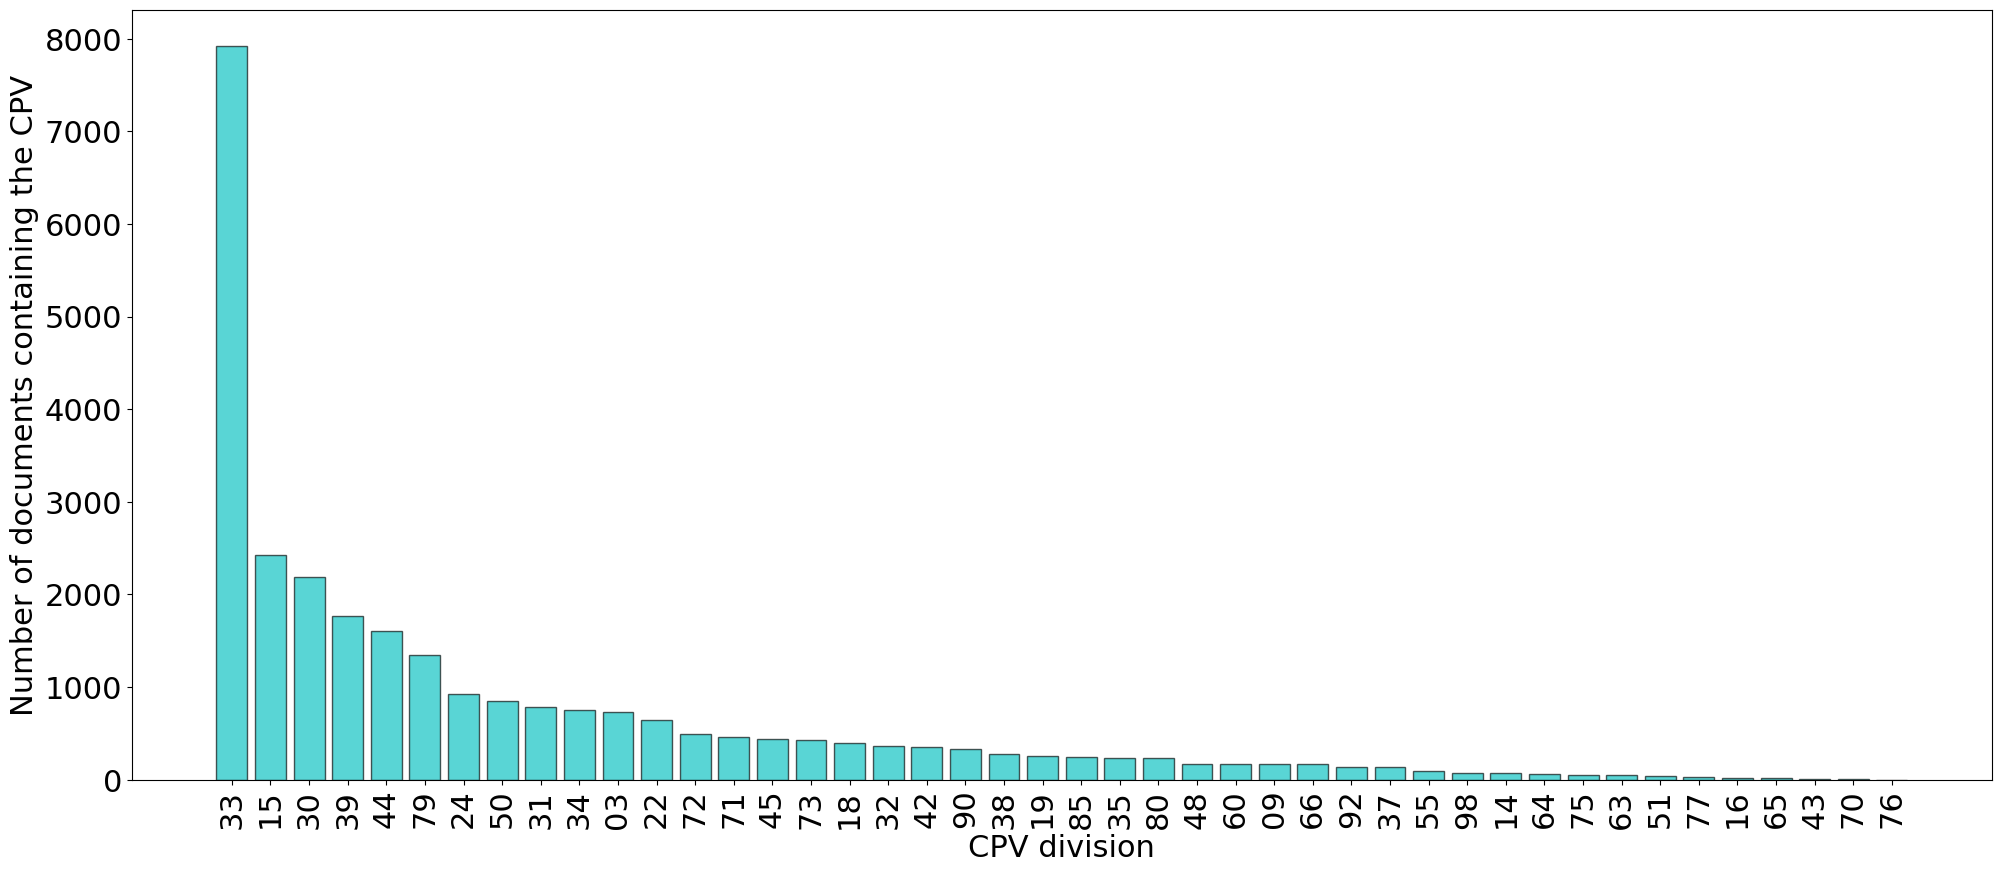

In [13]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


## Train model

In [14]:
from sklearn import metrics

X = df['title_description']
Y = df.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 40 is present in all training examples.
  warnings.warn(


clf fit done


In [15]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

          71       0.80      0.55      0.65        86
          44       0.77      0.61      0.68       325
          50       0.83      0.74      0.78       166
          80       0.91      0.61      0.73        51
          73       0.60      0.54      0.57        90
          45       0.81      0.55      0.66        83
          85       0.93      0.62      0.74        60
          79       0.76      0.67      0.71       266
          90       0.92      0.71      0.80        65
          30       0.84      0.79      0.82       437
          35       0.62      0.20      0.30        51
          33       0.92      0.90      0.91      1594
          55       0.90      0.47      0.62        19
          72       0.74      0.53      0.62       109
          48       0.75      0.32      0.45        37
          38       0.94      0.24      0.38        63
          09       0.93      0.36      0.52        36
          75       1.00    

## Predictions on data from other countries

In [16]:
list_of_countries = ["ie", "no", "uk", "eu"]
list_of_countries.remove(country_code)

for country in list_of_countries:
    df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country}_only_no_filters.csv", index_col=0)
    print("====================================================\n")
    print(f"Country: {country}")
    X = df['title_description']
    Y = df.drop(['title_description'], axis=1)
    y_pred = SVC_pipeline.predict(X)
    print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
    print(multi_label_metrics(Y, y_pred))
    print("====================================================\n")



Country: ie


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.87      0.06      0.11     14326
          44       0.32      0.00      0.00      5163
          50       0.58      0.17      0.26      5009
          80       0.84      0.36      0.50      4701
          73       0.33      0.17      0.22      3487
          45       0.96      0.12      0.22     23424
          85       0.76      0.06      0.11      2068
          79       0.56      0.40      0.46     13945
          90       0.84      0.18      0.30      4534
          30       0.68      0.12      0.21      3096
          35       0.00      0.00      0.00      1804
          33       0.36      0.03      0.06      3953
          55       0.88      0.31      0.46      1419
          72       0.63      0.35      0.45     10273
          48       0.66      0.03      0.06      4918
          38       0.82      0.07      0.12      3699
          09       0.89      0.03      0.06       957
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.84      0.06      0.11     20912
          44       0.07      0.00      0.01      9433
          50       0.42      0.02      0.04      7632
          80       0.63      0.03      0.06      6441
          73       0.34      0.04      0.07      6186
          45       0.84      0.00      0.01     85428
          85       0.45      0.01      0.01      4884
          79       0.44      0.17      0.25     13142
          90       0.86      0.07      0.13     11340
          30       0.68      0.04      0.07      7246
          35       0.00      0.00      0.00      2382
          33       0.19      0.03      0.05     12894
          55       0.80      0.02      0.03      1879
          72       0.49      0.12      0.19     13998
          48       0.61      0.01      0.02      8659
          38       0.71      0.02      0.04      5376
          09       1.00      0.01      0.02      1992
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.66      0.03      0.06     32218
          44       0.15      0.00      0.01     14264
          50       0.53      0.18      0.27     20363
          80       0.80      0.26      0.39     18155
          73       0.37      0.22      0.28     19875
          45       0.88      0.08      0.14     63683
          85       0.76      0.03      0.06     33984
          79       0.37      0.38      0.37     48598
          90       0.85      0.20      0.33     17154
          30       0.46      0.16      0.23      7103
          35       0.13      0.00      0.00      5395
          33       0.43      0.04      0.08     14999
          55       0.84      0.34      0.48      5015
          72       0.39      0.29      0.34     28095
          48       0.66      0.04      0.08     20149
          38       0.79      0.05      0.09     11902
          09       0.92      0.01      0.02      4144
          75       0.00    

## Predictions on dataset since january 2023
Dataset available on S3: s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20220221-dataset_since_january_2023.csv ; 

In [17]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [18]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline.predict(X)
print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

              precision    recall  f1-score   support

          71       0.67      0.22      0.33         9
          44       0.00      0.00      0.00         1
          50       1.00      0.33      0.50         3
          80       1.00      0.50      0.67         6
          73       0.25      0.14      0.18         7
          45       1.00      0.29      0.44        14
          85       1.00      0.67      0.80         3
          79       0.69      0.77      0.73        26
          90       1.00      0.57      0.73         7
          30       0.50      0.50      0.50         2
          35       1.00      0.33      0.50         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.56      0.71      0.63         7
          48       0.00      0.00      0.00         2
          38       1.00      1.00      1.00         1
          09       0.00      0.00      0.00         0
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

# With Filters above/below thresholds

In [19]:
import glob
import json
import pandas as pd
from fastlid import fastlid

cols = ['title_description', 'cpvs', 'size']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        size = element.get("size", None)
        if size:
            cpvs = element.get("cpvs", [])
            result_cpvs = []
            for cpv in cpvs:
                result = cpv.get("code", "na")
                if result and result != "na":
                    result = result[:2]
                    if result in all_divisions:
                        result_cpvs.append(result)
            title = element.get('title', '')
            if title:
                title = f'{title}. '
            description = element.get('description', '')

            title_description = f'{title}{description}'
            if result_cpvs and title_description:
                lst = [title_description, result_cpvs, size]
                data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-eu-json/data-eu-2020.json', 'data_json_opentender/data-eu-json/data-eu-2015.json', 'data_json_opentender/data-eu-json/data-eu-2018.json', 'data_json_opentender/data-eu-json/data-eu-2022.json', 'data_json_opentender/data-eu-json/data-eu-2009.json', 'data_json_opentender/data-eu-json/data-eu-2011.json', 'data_json_opentender/data-eu-json/data-eu-year-unavailable.json', 'data_json_opentender/data-eu-json/data-eu-2014.json', 'data_json_opentender/data-eu-json/data-eu-2013.json', 'data_json_opentender/data-eu-json/data-eu-2017.json', 'data_json_opentender/data-eu-json/data-eu-2012.json', 'data_json_opentender/data-eu-json/data-eu-2016.json', 'data_json_opentender/data-eu-json/data-eu-2019.json', 'data_json_opentender/data-eu-json/data-eu-2010.json', 'data_json_opentender/data-eu-json/data-eu-2021.json']


title_description  cpvs  \
15394  Servicii de elaborare Studiu de fezabilitate. ...  [79]   
15395  Tonere multifunctionale. Se achizitioneaza ton...  [30]   
15396  Achizitia de consumabile pentru imprimante. CO...  [30]   
15397  Ventilatoare pentru C.S. ROMANITA. VENTILATOR ...  [39]   
15398  Catetere IV / Flexule / Branula / Branule cu v...  [33]   

                      size  
15394  BELOW_THE_THRESHOLD  
15395  BELOW_THE_THRESHOLD  
15396  BELOW_THE_THRESHOLD  
15397  BELOW_THE_THRESHOLD  
15398  BELOW_THE_THRESHOLD

In [20]:
df = df.drop_duplicates(subset=['title_description'], keep='last')

In [21]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description                 size  \
0  Articole sanitare. HUSA PAT FROTIR 100X200 CM ...  BELOW_THE_THRESHOLD   

      71    44     50     80     73     45     85     79  ...     18     03  \
0  False  True  False  False  False  False  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
0  False  False  False  False  False  False  False  False  

[1 rows x 47 columns]

In [22]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                 12753
unique                                                12753
top        articole sanitare husa pat frotir NUMBERxNUMB...
freq                                                      1
Name: title_description, dtype: object

In [23]:
df.to_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv")

In [24]:
df = pd.read_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv", index_col=0)

In [25]:
df["size"].describe()

count                   12753
unique                      2
top       BELOW_THE_THRESHOLD
freq                    11584
Name: size, dtype: object

In [26]:
df["size"].unique()

array(['BELOW_THE_THRESHOLD', 'ABOVE_THE_THRESHOLD'], dtype=object)

In [27]:
df_below_threshold = df[df["size"] == "BELOW_THE_THRESHOLD"]
df_above_threshold = df[df["size"] == "ABOVE_THE_THRESHOLD"]
df_below_threshold.head()

title_description                 size  \
0   articole sanitare husa pat frotir NUMBERxNUMB...  BELOW_THE_THRESHOLD   
1   ace automat NUMBERl regular si calgon ace NUM...  BELOW_THE_THRESHOLD   
2   asigurare phoenix asigurare phoenix conform c...  BELOW_THE_THRESHOLD   
3   articole de papetarie si accesorii de birou a...  BELOW_THE_THRESHOLD   
4   placa pentru fracturi de femur distal conform...  BELOW_THE_THRESHOLD   

      71     44     50     80     73     45     85     79  ...     18     03  \
0  False   True  False  False  False  False  False  False  ...  False  False   
1  False  False  False  False  False  False  False  False  ...  False  False   
2   True  False  False  False  False  False  False  False  ...  False  False   
3  False  False  False  False  False  False  False  False  ...  False  False   
4  False  False  False  False  False  False  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
0  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

Text(0.5, 0, 'CPV division')

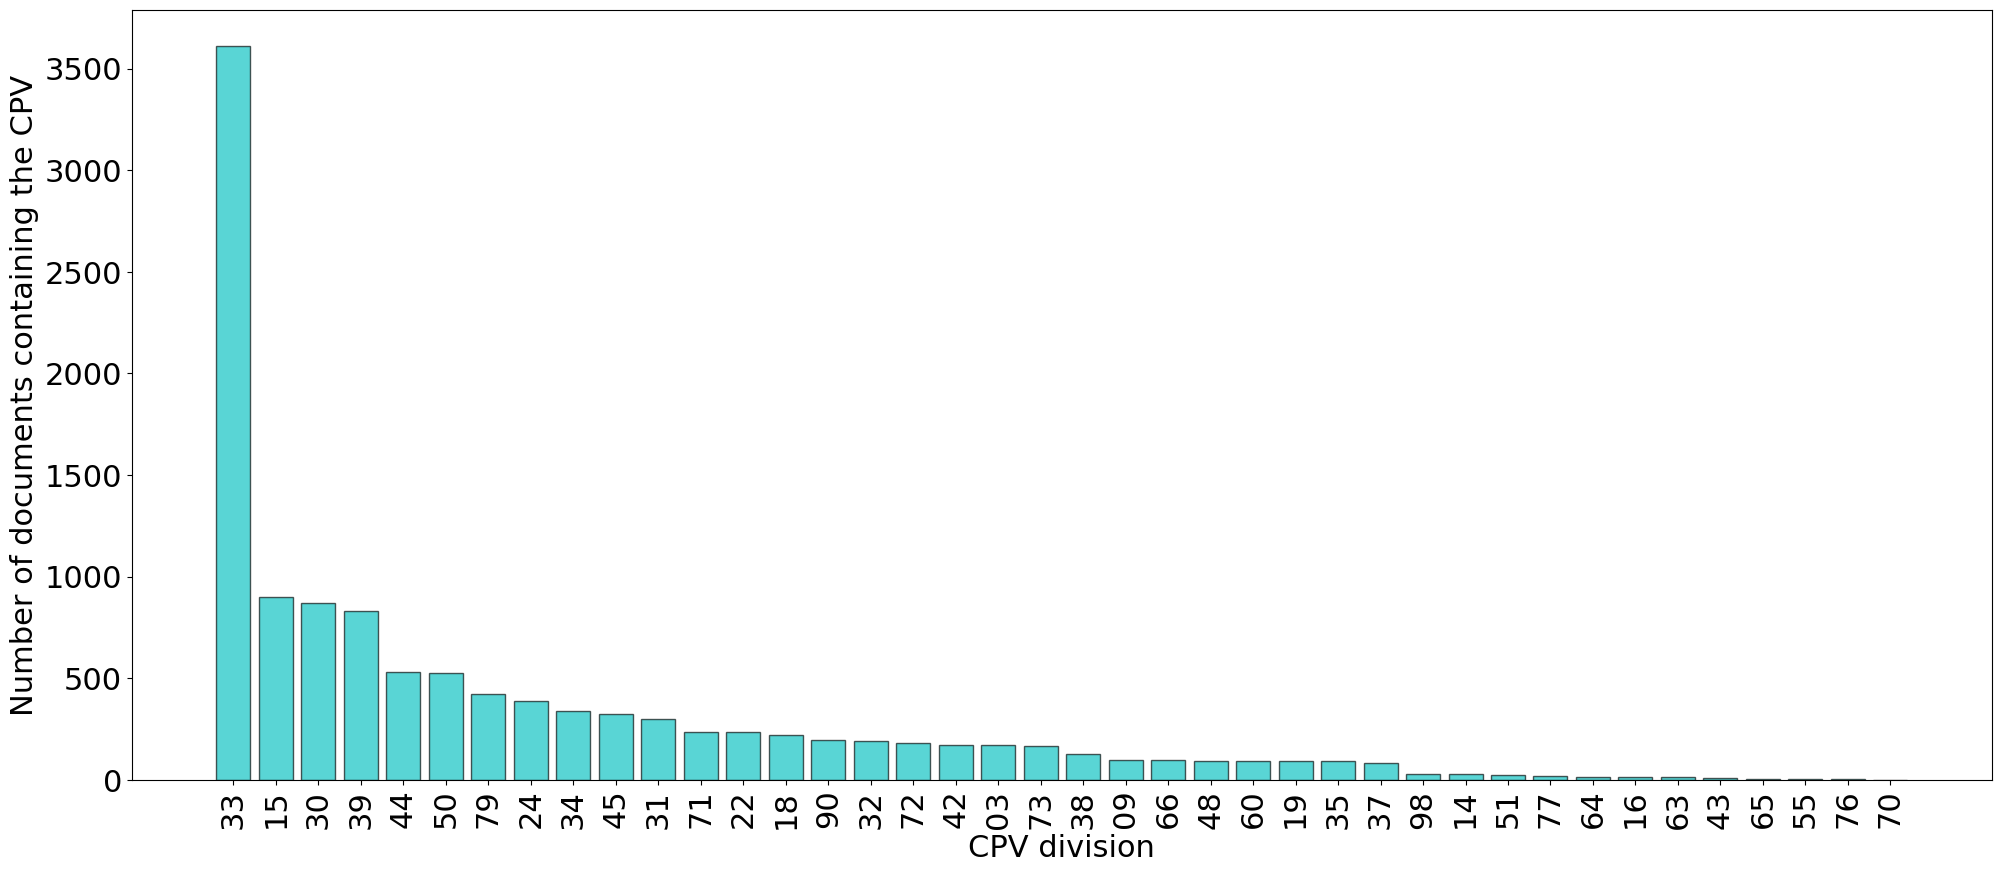

In [28]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_below_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


Text(0.5, 0, 'CPV division')

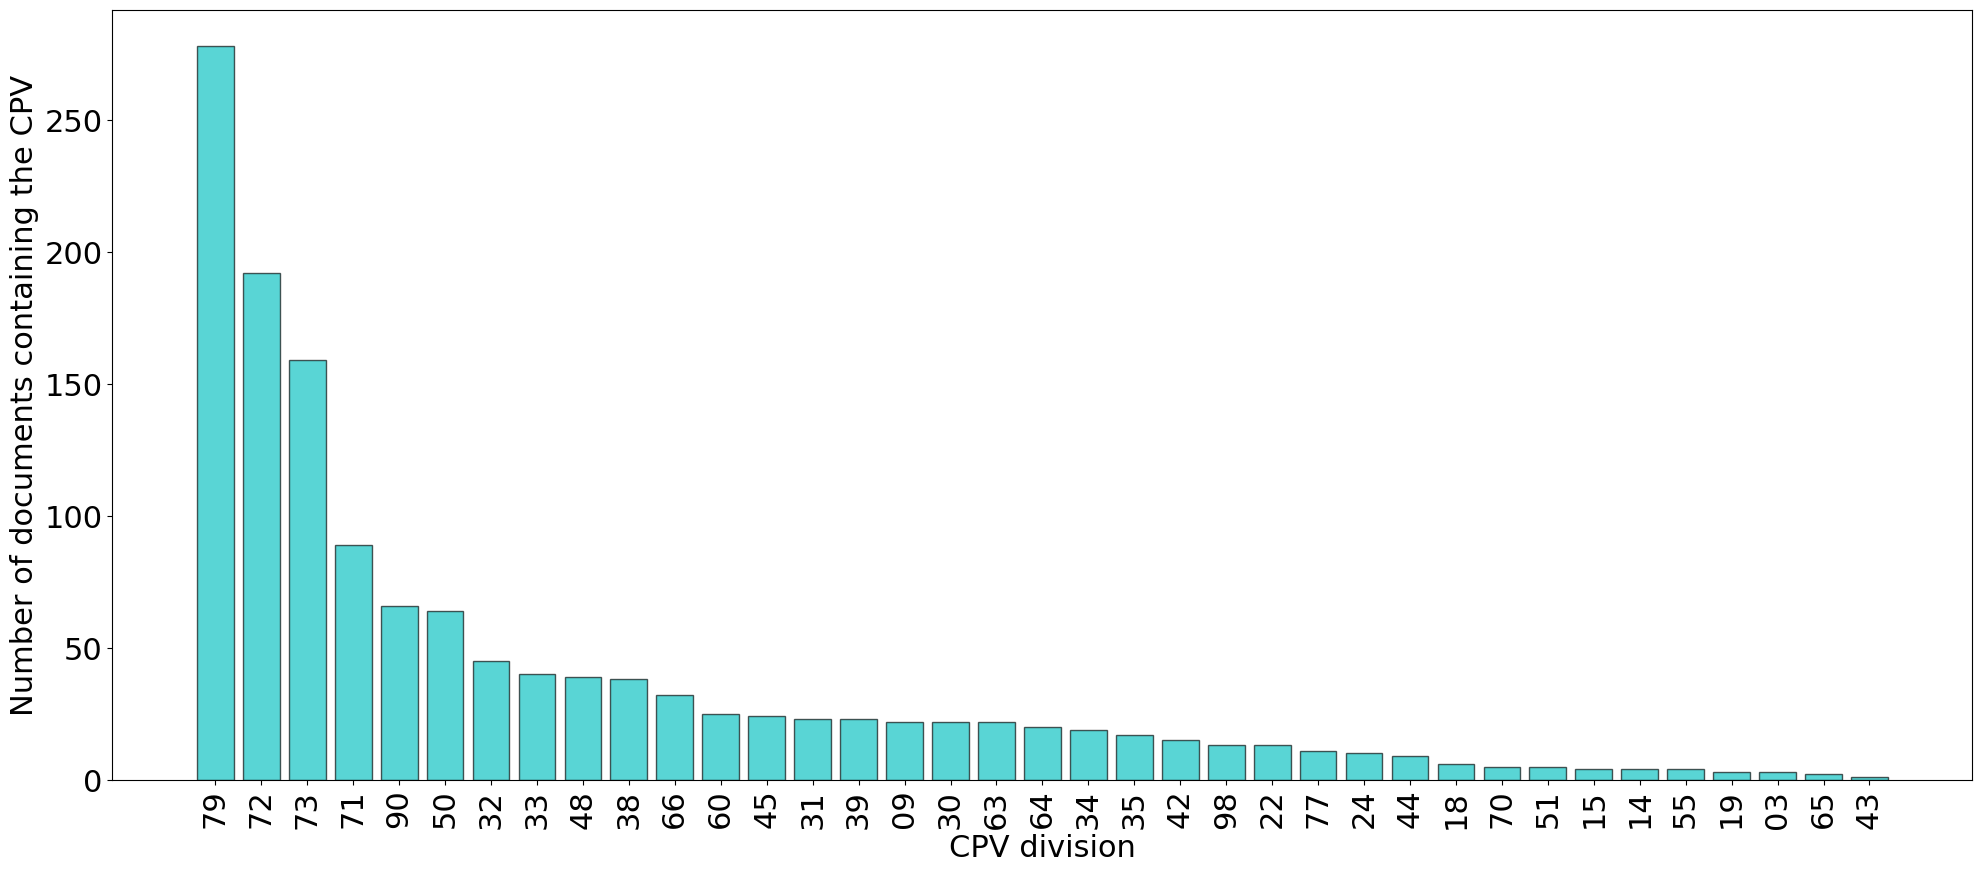

In [29]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_above_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


In [30]:
df_below_threshold.describe()

title_description  \
count                                               11584   
unique                                              11584   
top      articole sanitare husa pat frotir NUMBERxNUMB...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                 11584  11584  11584  11584  11584  11584  11584  11584   
unique                    1      2      2      2      1      2      2      1   
top     BELOW_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                  11584  11347  11056  11059  11584  11416  11259  11584   

           79  ...     18     03     43     24     19     41     37     14  \
count   11584  ...  11584  11584  11584  11584  11584  11584  11584  11584   
unique      2  ...      2      2      2      2      2      1      2      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq    11161  ...  11362  11413  11574  11195  11491  11584  11503  11558   

           16     76  
count   11584  11584  
unique      2      2  
top     False  False  
freq    11571  11582  

[4 rows x 47 columns]

In [31]:
df_above_threshold.describe()

title_description  \
count                                                1169   
unique                                               1169   
top      specialise child hospital burgas overall obje...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                  1169   1169   1169   1169   1169   1169   1169   1169   
unique                    1      2      2      2      1      2      2      1   
top     ABOVE_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                   1169   1080   1160   1105   1169   1010   1145   1169   

           79  ...     18     03     43     24     19     41     37     14  \
count    1169  ...   1169   1169   1169   1169   1169   1169   1169   1169   
unique      2  ...      2      2      2      2      2      1      1      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq      891  ...   1163   1166   1168   1159   1166   1169   1169   1165   

           16     76  
count    1169   1169  
unique      1      1  
top     False  False  
freq     1169   1169  

[4 rows x 47 columns]

In [32]:
df_above_threshold.head()

title_description                 size  \
1840   specialise child hospital burgas overall obje...  ABOVE_THE_THRESHOLD   
1841   action plan conservation threaten pollinator ...  ABOVE_THE_THRESHOLD   
1842   supply polychromator jt NUMBERsa thomson scat...  ABOVE_THE_THRESHOLD   
1843   entretien garantie totale et travaux specifiq...  ABOVE_THE_THRESHOLD   
1845   insurance assistance connection work relate t...  ABOVE_THE_THRESHOLD   

         71     44     50     80     73     45     85     79  ...     18  \
1840   True  False  False  False  False  False  False  False  ...  False   
1841  False  False  False  False  False  False  False  False  ...  False   
1842  False  False  False  False  False  False  False  False  ...  False   
1843  False  False   True  False  False  False  False  False  ...  False   
1845  False  False  False  False  False  False  False  False  ...  False   

         03     43     24     19     41     37     14     16     76  
1840  False  False  False  False  False  False  False  False  False  
1841  False  False  False  False  False  False  False  False  False  
1842  False  False  False  False  False  False  False  False  False  
1843  False  False  False  False  False  False  False  False  False  
1845  False  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

In [33]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
df_above_threshold = df_above_threshold.drop(["size"], axis = 1)
df_below_threshold = df_below_threshold.drop(["size"], axis = 1)

In [34]:
from sklearn import metrics

X = df_above_threshold['title_description']
Y = df_above_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_above = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_above.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_above.predict(X_test)
print("Above threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


clf fit done
Above threshold: 

              precision    recall  f1-score   support

          71       0.75      0.14      0.24        21
          44       0.00      0.00      0.00         4
          50       0.50      0.31      0.38        13
          80       0.00      0.00      0.00         0
          73       0.65      0.48      0.55        23
          45       0.00      0.00      0.00        10
          85       0.00      0.00      0.00         0
          79       0.86      0.49      0.62        61
          90       0.83      0.33      0.48        15
          30       1.00      0.33      0.50         3
          35       0.00      0.00      0.00         0
          33       1.00      0.44      0.62         9
          55       1.00      1.00      1.00         1
          72       0.80      0.53      0.64        30
          48       0.00      0.00      0.00         7
          38       1.00      0.11      0.20         9
          09       1.00      0.33      0.50      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 37 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 40 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 41 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 43 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 44 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sk

In [35]:
from sklearn import metrics

X = df_below_threshold['title_description']
Y = df_below_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_below = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_below.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_below.predict(X_test)
print("Below threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 40 is present in all training examples.
  warnings.warn(


clf fit done
Below threshold: 

              precision    recall  f1-score   support

          71       0.82      0.50      0.62        46
          44       0.80      0.54      0.64        95
          50       0.80      0.76      0.78        99
          80       0.00      0.00      0.00         0
          73       0.49      0.66      0.56        32
          45       0.64      0.45      0.53        60
          85       0.00      0.00      0.00         0
          79       0.64      0.47      0.54        87
          90       1.00      0.74      0.85        43
          30       0.88      0.79      0.83       200
          35       0.75      0.17      0.27        18
          33       0.90      0.90      0.90       697
          55       0.00      0.00      0.00         1
          72       0.65      0.31      0.42        36
          48       0.82      0.45      0.58        20
          38       0.78      0.32      0.45        22
          09       0.78      0.70      0.74      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

{'f1': 0.7536643026004727, 'roc_auc': 0.837606441130209, 'accuracy': 0.6594734570565386, 'coverage_error': 14.963314630988346, 'label_ranking_average_precision_score': 0.6805447657411325}
None


## Against eu institution notices from january 2023

In [36]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [37]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_above.predict(X)
print("Above threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Above threshold: 

              precision    recall  f1-score   support

          71       1.00      0.33      0.50         9
          44       0.00      0.00      0.00         1
          50       0.00      0.00      0.00         3
          80       0.00      0.00      0.00         6
          73       0.00      0.00      0.00         7
          45       0.00      0.00      0.00        14
          85       0.00      0.00      0.00         3
          79       0.83      0.38      0.53        26
          90       1.00      0.43      0.60         7
          30       1.00      0.50      0.67         2
          35       1.00      0.33      0.50         3
          33       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         2
          72       0.42      0.71      0.53         7
          48       0.00      0.00      0.00         2
          38       0.00      0.00      0.00         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [38]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_below.predict(X)
print("Below threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Below threshold: 

              precision    recall  f1-score   support

          71       0.00      0.00      0.00         9
          44       0.00      0.00      0.00         1
          50       0.20      0.33      0.25         3
          80       0.00      0.00      0.00         6
          73       0.33      0.29      0.31         7
          45       0.00      0.00      0.00        14
          85       0.00      0.00      0.00         3
          79       0.57      0.62      0.59        26
          90       1.00      0.43      0.60         7
          30       0.00      0.00      0.00         2
          35       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         2
          72       0.67      0.29      0.40         7
          48       0.00      0.00      0.00         2
          38       1.00      1.00      1.00         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a